In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zupt import Init_det_glrt 
from zupt.ZUPTaidedINS import *
from zupt import func_loaddataset
from zupt.detector import detector_adaptive

In [2]:
def plot_position_tracking(imu_data):
    """
    Plots the 2D top view of position tracking from IMU data.

    Parameters:
    imu_data (numpy.ndarray): IMU data array of shape (9, N) where the first two rows are x and y coordinates.
    """
    # Extract x and y positions
    x_positions = imu_data[0, :]  # X coordinates
    y_positions = imu_data[1, :]  # Y coordinates

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.plot(x_positions, y_positions, marker='o', linestyle='-', color='b', zorder=1)
    plt.title('2D Top View Position Tracking')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True)
    plt.axis('equal')  # This ensures that unit increments are equal on both axes

    # Highlight the first position with higher zorder
    plt.scatter(x_positions[0], y_positions[0], color='green', s=100, edgecolor='black', label='Start', zorder=2)
    # Highlight the last position with higher zorder
    plt.scatter(x_positions[-1], y_positions[-1], color='red', s=100, edgecolor='black', label='End', zorder=2)

    # Add a legend to identify the start and end
    plt.legend()

    # Display the plot
    plt.show()

def plot_z_position_tracking(imu_data):
    """
    Plots the changes in the z-position over time from IMU data.

    Parameters:
    imu_data (numpy.ndarray): IMU data array of shape (9, N) where the third row is the z coordinate.
    """
    # Extract z positions
    z_positions = imu_data[2, :]  # Z coordinates

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.plot(z_positions, marker='o', linestyle='-', color='c')  # 'c' for cyan color
    plt.title('Z-Position Tracking Over Time')
    plt.xlabel('Time or Sequence Index')
    plt.ylabel('Z Position')
    plt.grid(True)

    # Display the plot
    plt.show()

def load_imu_data(file_path):
    """
    Load and convert IMU data from a given CSV file.

    Parameters:
    file_path (str): Path to the CSV file containing IMU data.

    Returns:
    numpy.ndarray: Transposed array containing converted IMU data.
    """
    # Read the dataset assuming comma-separated values without headers
    data = pd.read_csv(file_path, header=None, names=['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z'])
    # Create an array of the modified data
    u = data.to_numpy().T

    return u


Main

In [3]:
simdata = Init_det_glrt.Init_det_glrt()
# Variables for calculating the performance
D = len(simdata['data_sets'])
Jadapt = 0
Jadapt_all = np.zeros((D, 3))
gamma_vec = np.logspace(4, 6, 20)
M = len(gamma_vec)
ctr = 1
Niter = M
Jfixed = np.zeros(M)
Jfixed_all = np.zeros((M, D, 3))

## INS class

In [4]:
import numpy as np
from omegaconf import OmegaConf
import time
import keyboard
from threading import Lock
import numpy as np
import xsensdeviceapi as xda

In [5]:
def q2dcm(q):
    p = np.zeros(6)
    p[0:4] = q ** 2
    p[4] = p[1] + p[2]
    p[5] = 2 / (p[0] + p[3] + p[4]) if (p[0] + p[3] + p[4]) != 0 else 0

    R = np.zeros((3, 3))
    R[0, 0] = 1 - p[5] * p[4]
    R[1, 1] = 1 - p[5] * (p[0] + p[2])
    R[2, 2] = 1 - p[5] * (p[0] + p[1])

    p[0] = p[5] * q[0]
    p[1] = p[5] * q[1]
    p[4] = p[5] * q[2] * q[3]
    p[5] = p[0] * q[1]

    R[0, 1] = p[5] - p[4]
    R[1, 0] = p[5] + p[4]
    p[4] = p[1] * q[3]
    p[5] = p[0] * q[2]
    R[0, 2] = p[5] + p[4]
    R[2, 0] = p[5] - p[4]
    p[4] = p[0] * q[3]
    p[5] = p[1] * q[2]
    R[1, 2] = p[5] - p[4]
    R[2, 1] = p[5] + p[4]

    return R

def dcm2q(R):
    T = 1 + R[0, 0] + R[1, 1] + R[2, 2]

    if T > 1e-8:
        S = 0.5 / np.sqrt(T)
        qw = 0.25 / S
        qx = (R[2, 1] - R[1, 2]) * S
        qy = (R[0, 2] - R[2, 0]) * S
        qz = (R[1, 0] - R[0, 1]) * S
    else:
        if (R[0, 0] > R[1, 1]) and (R[0, 0] > R[2, 2]):
            S = np.sqrt(1 + R[0, 0] - R[1, 1] - R[2, 2]) * 2
            qw = (R[2, 1] - R[1, 2]) / S
            qx = 0.25 * S
            qy = (R[0, 1] + R[1, 0]) / S
            qz = (R[0, 2] + R[2, 0]) / S
        elif R[1, 1] > R[2, 2]:
            S = np.sqrt(1 + R[1, 1] - R[0, 0] - R[2, 2]) * 2
            qw = (R[0, 2] - R[2, 0]) / S
            qx = (R[0, 1] + R[1, 0]) / S
            qy = 0.25 * S
            qz = (R[1, 2] + R[2, 1]) / S
        else:
            S = np.sqrt(1 + R[2, 2] - R[0, 0] - R[1, 1]) * 2
            qw = (R[1, 0] - R[0, 1]) / S
            qx = (R[0, 2] + R[2, 0]) / S
            qy = (R[1, 2] + R[2, 1]) / S
            qz = 0.25 * S

    return np.array([qx, qy, qz, qw])

def Rt2b(ang):
    cr = np.cos(ang[0])
    sr = np.sin(ang[0])
    cp = np.cos(ang[1])
    sp = np.sin(ang[1])
    cy = np.cos(ang[2])
    sy = np.sin(ang[2])

    R = np.array([
        [cy * cp, sy * cp, -sp],
        [-sy * cr + cy * sp * sr, cy * cr + sy * sp * sr, cp * sr],
        [sy * sr + cy * sp * cr, -cy * sr + sy * sp * cr, cp * cr]
    ])
    return R

In [6]:

class Payload:
    def __init__(self):
        self.timestamp = []
        self.acc = np.array([0, 0, 0])
        self.angular_velocity = np.array([0, 0, 0])

class XdaCallback(xda.XsCallback):
    def __init__(self, max_buffer_size=5):
        super().__init__()
        self.m_maxNumberOfPacketsInBuffer = max_buffer_size
        self.m_packetBuffer = list()
        self.m_lock = Lock()

    def packetAvailable(self):
        with self.m_lock:
            return len(self.m_packetBuffer) > 0

    def getNextPacket(self):
        with self.m_lock:
            assert len(self.m_packetBuffer) > 0
            return xda.XsDataPacket(self.m_packetBuffer.pop(0))

    def onLiveDataAvailable(self, dev, packet):
        with self.m_lock:
            assert packet is not None
            if len(self.m_packetBuffer) >= self.m_maxNumberOfPacketsInBuffer:
                self.m_packetBuffer.pop(0)
            self.m_packetBuffer.append(xda.XsDataPacket(packet))

class Scanner:
    def __init__(self, sample_rate=100, retries=3, wait_time=1):
        self.control = xda.XsControl_construct()
        assert(self.control != 0)
        self.device = None
        self.sample_rate = sample_rate
        self.retries = retries
        self.wait_time = wait_time

    def scan_and_open(self):
        attempt = 0
        while attempt < self.retries:
            print("Scanning for devices... Attempt:", attempt + 1)
            portInfoArray = xda.XsScanner_scanPorts()
            
            mtPort = xda.XsPortInfo()
            for i in range(portInfoArray.size()):
                if portInfoArray[i].deviceId().isMti() or portInfoArray[i].deviceId().isMtig():
                    mtPort = portInfoArray[i]
                    break
            
            if mtPort.empty():
                print("No MTi device found. Retrying...")
                attempt += 1
                time.sleep(self.wait_time)
                continue
            
            did = mtPort.deviceId()
            print(f"Found a device with ID: {did.toXsString()}, Port: {mtPort.portName()}")

            if not self.control.openPort(mtPort.portName(), mtPort.baudrate()):
                raise RuntimeError("Could not open port. Aborting.")
            
            self.device = self.control.device(did)
            assert self.device is not None
            print(f"Device {self.device.productCode()} with ID {self.device.deviceId().toXsString()} opened.")

            self.device.addCallbackHandler(XdaCallback())  # add Callback
            self.configure_device()
            return self.device
        
        raise RuntimeError("No MTi device found after multiple attempts. Aborting.")

    def close(self):
        if self.device:
            self.device.stopRecording()
            self.device.closeLogFile()
        if self.control:
            self.control.close()
        print("Disconnected successfully.")
    
    def get_device_info(self):
        if self.device:
            device_info = {
                "Product Code": self.device.productCode(),
                "Device ID": self.device.deviceId().toXsString(),
                "Firmware Version": self.device.firmwareVersion().toXsString()
            }
            return device_info
        return {}

    def configure_device(self):
        print("Putting device into configuration mode...")
        if not self.device.gotoConfig():
            raise RuntimeError("Could not put device into configuration mode. Aborting.")
        configArray = xda.XsOutputConfigurationArray()
        configArray.push_back(xda.XsOutputConfiguration(xda.XDI_PacketCounter, 0))
        configArray.push_back(xda.XsOutputConfiguration(xda.XDI_SampleTimeFine, 0))
        configArray.push_back(xda.XsOutputConfiguration(xda.XDI_Acceleration, 100))  # 100Hz
        configArray.push_back(xda.XsOutputConfiguration(xda.XDI_RateOfTurn, 100))  # 100Hz
        configArray.push_back(xda.XsOutputConfiguration(xda.XDI_Quaternion, 100))  # 100Hz

        if not self.device.setOutputConfiguration(configArray):
            raise RuntimeError("Failed to configure device")

        print("Creating a log file...")
        logFileName = "logfile.mtb"
        if self.device.createLogFile(logFileName) != xda.XRV_OK:
            raise RuntimeError("Failed to create a log file. Aborting.")
        else:
            print("Created a log file: %s" % logFileName)

        print("Putting device into measurement mode...")
        if not self.device.gotoMeasurement():
            raise RuntimeError("Could not put device into measurement mode. Aborting.")

        print("Starting recording...")
        if not self.device.startRecording():
            raise RuntimeError("Failed to start recording. Aborting.")


In [7]:
class INS:
    def __init__(self, config, adpt_flag = True) -> None:
        self.config = config
        self.general_params = self.config.general_parameters
        self.detector_set = self.config.detector_settings
        self.filter_params =  self.config.filter_parameters
        

        self.adpt_flag = adpt_flag

        # other objects
        self.sensor = Scanner(self.general_params.sample_rate)

        # general parameters #
        self.g = self.gravity(
            self.general_params.latitude,
            self.general_params.latitude)
        self.Ts = 1 / self.general_params.sample_rate
        self.init_pos = np.array(self.general_params.init_pos)
        self.init_heading = self.general_params.init_heading 

        # detector_settings #
        self.detector_type = self.detector_set.detector_type
        self.sigma_a = self.detector_set.sigma_a
        self.sigma_g = 0.1 * np.pi / 180
        # self.sigma_g = self.detector_set.sigma_g
        self.Window_size = self.detector_set.Window_size
        self.gamma = self.detector_set.gamma
        self.detector_prio = self.detector_set.detector_prio

        # filter parameters #
        self.biases = self.filter_params.biases
        self.scalefactors = self.filter_params.scalefactors
        # self.sigma_acc = np.array(self.filter_params.sigma_acc)
        self.sigma_acc = np.array([1, 1, 1]) * 1.3 
        self.sigma_gyro = np.array([1, 1, 1]) * np.pi * 0.01
        self.acc_bias_driving_noise = np.array(self.filter_params.acc_bias_driving_noise)
        # self.gyro_bias_driving_noise = np.array(self.filter_params.gyro_bias_driving_noise)
        self.gyro_bias_driving_noise = 0.0000001 * np.pi / 180
        self.sigma_vel = np.array(self.filter_params.sigma_vel)
        self.sigma_initial_pos = np.array(self.filter_params.sigma_initial_pos)
        self.sigma_initial_vel = np.array(self.filter_params.sigma_initial_vel)
        self.sigma_initial_att = np.array([1, 1, 0.1]) * 0.3 * np.pi / 180
        # self.sigma_initial_att = np.array(self.filter_params.sigma_initial_att)
        self.sigma_initial_acc_bias = np.array([1, 1, 1]) * 0.3
        self.sigma_initial_gyro_bias = np.array([1, 1, 1]) * 0.3 * np.pi / 180
        # self.sigma_initial_acc_bias = np.array(self.filter_params.sigma_initial_acc_bias)
        # self.sigma_initial_gyro_bias = np.array(self.filter_params.sigma_initial_gyro_bias)
        self.sigma_initial_acc_scale = np.array([1, 1, 1]) * 0.0001
        self.sigma_initial_gyro_scale = np.array([1, 1, 1]) * 0.00001
        # self.sigma_initial_acc_scale = np.array(self.filter_params.sigma_initial_acc_scale)
        # self.sigma_initial_gyro_scale = np.array(self.filter_params.sigma_initial_gyro_scale)

        self.acc_bias_instability_time_constant_filter = float('inf')
        self.gyro_bias_instability_time_constant_filter = float('inf')
        # self.acc_bias_instability_time_constant_filter = float(self.filter_params.acc_bias_instability_time_constant_filter)
        # self.gyro_bias_instability_time_constant_filter = float(self.filter_params.gyro_bias_instability_time_constant_filter)

    @staticmethod
    def load_config(file_path):
        return OmegaConf.load(file_path)
    
    @staticmethod
    def gravity(latitude, altitude):
        lambda_rad = np.pi / 180 * latitude
        gamma = 9.780327 * (1 + 0.0053024 * np.sin(lambda_rad) ** 2 - 0.0000058 * np.sin(2 * lambda_rad) ** 2)
        g = gamma - ((3.0877e-6) - (0.004e-6) * np.sin(lambda_rad) ** 2) * altitude + (0.072e-12) * altitude ** 2
        return g
    
    def detector(self, u_in):
        return self.detector_adaptive(u_in)

    def baseline(self, imu_data, zupt, logL, initial_state = None, init_quat=None, initial_P= None):
        N = len(imu_data[0])
        P, Q, R, H = self.init_filter(initial_P)
        x_h, cov, Id = self.init_vec(N, P)
        if initial_state is None and init_quat is None:
            x_h[0:9, 0], quat = self.init_Nav_eq(imu_data)
        else:
            x_h[0:9, 0] = initial_state
            quat = init_quat


        if self.adpt_flag:
            zupt = np.zeros((1, len(logL[0] + 5)), dtype=bool)
            delta_t = 0
            gamma = np.zeros(len(logL[0]))
            if self.detector_prio == 'normalized velocity':
                c1, c2, c3 = -1e2 * self.Window_size / 2, -5e4 * self.Window_size / 2, 100
            else:
                c1, c2, c3 = -1e2 * self.Window_size / 2, -5e4 * self.Window_size / 2, 0
        
        for k in range(1, N):
            u_h = self.comp_imu_errors(imu_data[:, k], x_h[:, k-1])
            x_h[:, k] , quat = self.Navigation_equations(x_h[:, k-1], u_h, quat)
            F , G = self.state_matrix(quat, u_h)

            P = F @ P @ F.T + G @ Q @ G.T
            P = (P + P.T) / 2
            cov[:, k] = np.diag(P)            
            
            if self.adpt_flag:
                S = P[3:6, 3:6]
                v = x_h[3:6, k]
    
                gamma[k] = c1 + c2 * delta_t + c3 * (v.T @ np.linalg.inv(S) @ v)
                if logL[0][k] > gamma[k]:
                    zupt[0][k:k + self.Window_size] = True
                    delta_t = 0
                else:
                    delta_t += self.Ts


            if zupt[0][k]:
                K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
                z = -x_h[3:6, k]
                dx = K @ z
                x_h[:, k], quat = self.comp_internal_states(x_h[:, k], dx, quat)
                P = (Id - K @ H) @ P
                P = (P + P.T) / 2
                cov[:, k] = np.diag(P) # take last P to use in the next batch (covarnace of the estimate)
        
        if self.adpt_flag:
            t = self.Ts * np.arange(N)
            gamma[gamma > -1e2] = -1e1
            self.t = t
            self.gamma_list = gamma
        
        return x_h , cov, quat, P # change from cov to P
    
    def init_vec(self, N, P):
        if self.scalefactors == 'on' and self.biases == 'on':
            cov = np.zeros((9 + 6 + 6, N))
            x_h = np.zeros((9 + 6 + 6, N))
        elif self.scalefactors == 'on' and self.biases == 'off':
            cov = np.zeros((9 + 6, N))
            x_h = np.zeros((9 + 6, N))
        elif self.scalefactors == 'off' and self.biases == 'on':
            cov = np.zeros((9 + 6, N))
            x_h = np.zeros((9 + 6, N))
        else:
            cov = np.zeros((9, N))
            x_h = np.zeros((9, N))
        Id = np.eye(P.shape[0])
        cov[:, 0] = np.diag(P)
        return x_h, cov, Id
    
    def init_Nav_eq(self, imu_data): # checked
        f_u = np.mean(imu_data[0, :20])
        f_v = np.mean(imu_data[1, :20])
        f_w = np.mean(imu_data[2, :20])

        roll = np.arctan2(-f_v, -f_w)
        pitch = np.arctan2(f_u, np.sqrt(f_v ** 2 + f_w ** 2))


        attitude = np.array([roll, pitch, self.init_heading])
        Rb2t = Rt2b(attitude).T
        quat = dcm2q(Rb2t)

        x = np.zeros(9)
        x[0:3] = self.init_pos
        x[6:9] = attitude
        return x, quat

    def init_filter(self, initial_cov=None): # checked
        if self.scalefactors == 'on' and self.biases == 'on':
            P = np.zeros((9 + 6 + 6, 9 + 6 + 6))
            P[9:12, 9:12] = np.diag(self.sigma_initial_acc_bias ** 2)
            P[12:15, 12:15] = np.diag(self.sigma_initial_gyro_bias ** 2)
            P[15:18, 15:18] = np.diag(self.sigma_initial_acc_scale ** 2)
            P[18:21, 18:21] = np.diag(self.sigma_initial_gyro_scale ** 2)
            Q = np.zeros((12, 12))
            Q[6:9, 6:9] = np.diag(self.acc_bias_driving_noise ** 2)
            Q[9:12, 9:12] = np.diag(self.gyro_bias_driving_noise ** 2)
            H = np.zeros((3, 9 + 6 + 6))
        elif self.scalefactors == 'on' and self.biases == 'off':
            P = np.zeros((9 + 6, 9 + 6))
            P[9:12, 9:12] = np.diag(self.sigma_initial_acc_scale ** 2)
            P[12:15, 12:15] = np.diag(self.sigma_initial_gyro_scale ** 2)
            Q = np.zeros((6, 6))
            H = np.zeros((3, 9 + 6))
        elif self.scalefactors == 'off' and self.biases == 'on':
            P = np.zeros((9 + 6, 9 + 6))
            P[9:12, 9:12] = np.diag(self.sigma_initial_acc_bias ** 2)
            P[12:15, 12:15] = np.diag(self.sigma_initial_gyro_bias ** 2)
            Q = np.zeros((12, 12))
            Q[6:9, 6:9] = np.diag(self.acc_bias_driving_noise ** 2)
            Q[9:12, 9:12] = np.diag(self.gyro_bias_driving_noise ** 2)
            H = np.zeros((3, 9 + 6))
        else:
            if initial_cov is None:
                P = np.zeros((9, 9))
            else:
                P = initial_cov # should have size of (9, 9)
            Q = np.zeros((6, 6))
            H = np.zeros((3, 9))

        if initial_cov is None: 
            P[0:3, 0:3] = np.diag(self.sigma_initial_pos ** 2)
            P[3:6, 3:6] = np.diag(self.sigma_initial_vel ** 2)
            P[6:9, 6:9] = np.diag(self.sigma_initial_att ** 2)
        
        Q[0:3, 0:3] = np.diag(self.sigma_acc ** 2)
        Q[3:6, 3:6] = np.diag(self.sigma_gyro ** 2)
        R = np.diag(self.sigma_vel ** 2)
        H[0:3, 3:6] = np.eye(3)

        return P, Q, R, H
    

    def Navigation_equations(self, x, u, q): # checked
        y = np.zeros_like(x)
        Ts = self.Ts

        w_tb = u[3:6]
        P = w_tb[0] * Ts
        Q = w_tb[1] * Ts
        R = w_tb[2] * Ts

        OMEGA = np.array([[0, R, -Q, P], [-R, 0, P, Q], [Q, -P, 0, R], [-P, -Q, -R, 0]]) * 0.5

        v = np.linalg.norm(w_tb) * Ts
        if v != 0:
            q = (np.cos(v / 2) * np.eye(4) + 2 / v * np.sin(v / 2) * OMEGA) @ q
            q = q / np.linalg.norm(q)

        Rb2t = q2dcm(q) # checked
        y[6] = np.arctan2(Rb2t[2, 1], Rb2t[2, 2])
        y[7] = -np.arctan(Rb2t[2, 0] / np.sqrt(1 - Rb2t[2, 0] ** 2))
        y[8] = np.arctan2(Rb2t[1, 0], Rb2t[0, 0])

        g_t = np.array([0, 0, self.g])
        f_t = Rb2t @ u[0:3]
        acc_t = f_t + g_t

        A = np.eye(6)
        A[0, 3] = Ts
        A[1, 4] = Ts
        A[2, 5] = Ts
        B = np.vstack(((Ts ** 2) / 2 * np.eye(3), Ts * np.eye(3)))

        y[0:6] = A @ x[0:6] + B @ acc_t

        return y, q
    
    def state_matrix(self, q, u): # checked
        Rb2t = q2dcm(q)
        f_t = Rb2t @ u[0:3]
        St = np.array([[0, -f_t[2], f_t[1]], [f_t[2], 0, -f_t[0]], [-f_t[1], f_t[0], 0]])

        O = np.zeros((3, 3))
        I = np.eye(3)
        Da = np.diag(u[0:3])
        Dg = np.diag(u[3:6])

        B1 = -1 / self.acc_bias_instability_time_constant_filter * np.eye(3)
        B2 = -1 / self.gyro_bias_instability_time_constant_filter * np.eye(3)

        if self.scalefactors == 'on' and self.biases == 'on':
            Fc = np.block([
                [O, I, O, O, O, O, O],
                [O, O, St, Rb2t, O, Rb2t @ Da, O],
                [O, O, O, O, -Rb2t, O, -Rb2t @ Dg],
                [O, O, O, B1, O, O, O],
                [O, O, O, O, B2, O, O],
                [O, O, O, O, O, O, O],
                [O, O, O, O, O, O, O]
            ])
            Gc = np.block([
                [O, O, O, O],
                [Rb2t, O, O, O],
                [O, -Rb2t, O, O],
                [O, O, I, O],
                [O, O, O, I],
                [O, O, O, O],
                [O, O, O, O]
            ])
        elif self.scalefactors == 'on' and self.biases == 'off':
            Fc = np.block([
                [O, I, O, O, O],
                [O, O, St, Rb2t @ Da, O],
                [O, O, O, O, -Rb2t @ Dg],
                [O, O, O, O, O],
                [O, O, O, O, O]
            ])
            Gc = np.block([
                [O, O],
                [Rb2t, O],
                [O, -Rb2t],
                [O, O],
                [O, O]
            ])
        elif self.scalefactors == 'off' and self.biases == 'on':
            Fc = np.block([
                [O, I, O, O, O],
                [O, O, St, Rb2t, O],
                [O, O, O, O, -Rb2t],
                [O, O, O, B1, O],
                [O, O, O, O, B2]
            ])
            Gc = np.block([
                [O, O, O, O],
                [Rb2t, O, O, O],
                [O, -Rb2t, O, O],
                [O, O, I, O],
                [O, O, O, I]
            ])
        else:
            Fc = np.block([
                [O, I, O],
                [O, O, St],
                [O, O, O]
            ])
            Gc = np.block([
                [O, O],
                [Rb2t, O],
                [O, -Rb2t]
            ])

        F = np.eye(Fc.shape[0]) + (self.Ts * Fc)
        G = self.Ts * Gc
        return F, G


    def comp_internal_states(self, x_in, dx, q_in):
        R = q2dcm(q_in)
        x_out = x_in + dx
        epsilon = dx[6:9]

        OMEGA = np.array([[0, -epsilon[2], epsilon[1]], 
                    [epsilon[2], 0, -epsilon[0]], 
                    [-epsilon[1], epsilon[0], 0]])
        

        R = (np.eye(3) - OMEGA) @ R
        
        x_out[6] = np.arctan2(R[2, 1], R[2, 2])
        # R20_clamped = np.clip(R[2, 0], -1.0, 1.0)
        # x_out[7] = -np.arctan(R20_clamped / np.sqrt(1 - R20_clamped**2))
        x_out[7] = -np.arctan(R[2, 0] / np.sqrt(1 - R[2, 0] ** 2))
        x_out[8] = np.arctan2(R[1, 0], R[0, 0])

        q_out = dcm2q(R)
        return x_out, q_out

    def comp_imu_errors(self, u_in, x_h):
        if self.scalefactors == 'on' and self.biases == 'on':
            # temp = 1 / (1 - x_h[15:])
            temp = 1 / (np.ones(6) - x_h[15:])
            u_out = np.diag(temp) @ u_in + x_h[9:15]
        elif self.scalefactors == 'on' and self.biases == 'off':
            temp = 1 / (np.ones(6) - x_h[9:])
            u_out = np.diag(temp) @ u_in
        elif self.scalefactors == 'off' and self.biases == 'on':
            u_out = u_in + x_h[9:]
        else:
            u_out = u_in
        return u_out
    
    # detector side
    def detector_adaptive(self, u):
        zupt = np.zeros((1, (len(u[0]))))
        # Run the desired detector type
        if self.detector_type == 'GLRT':
            T = self.GLRT(u)
        elif self.detector_type == 'MV':
            T = self.MV(u)
        elif self.detector_type == 'MAG':
            T = self.MAG(u)
        elif self.detector_type == 'ARE':
            T = self.ARE(u)
        else:
            print('The chosen detector type is not recognized. The GLRT detector is used')
            T = self.GLRT(u)
        
        W = self.Window_size
        for k in range(len(T)):
            if T[k] < self.gamma:
                zupt[0][k:k+W] = 1
        
        # Fix the edges of the detector statistics
        T = np.concatenate((np.full(int(np.floor(W/2)), max(T)), T, np.full(int(np.floor(W/2)), max(T))))
        
        # Log-likelihood
        logL = -W / 2 * T

        return zupt, logL.reshape(1,-1)

    def GLRT(self, u):
        """
        Function that runs the generalized likelihood test (SHOE detector).
        """
        g = self.g
        sigma2_a = self.sigma_a ** 2
        sigma2_g = self.sigma_g ** 2
        W = self.Window_size

        N = len(u[0])
        # print(N, '-',W)
        # temp_size = min(N - W + 1,1)
        T = np.zeros(N - W + 1)
        for k in range(N - W + 1):
            ya_m = np.mean(u[0:3, k:k+W], axis=1)
            for l in range(k, k + W):
                tmp = u[0:3, l] - g * ya_m / np.linalg.norm(ya_m)
                T[k] += np.dot(u[3:6, l], u[3:6, l]) / sigma2_g + np.dot(tmp, tmp) / sigma2_a

        T = T / W

        return T

    def MV(self, u):
        """
        Function that runs the acceleration moving variance detector.
        """
        sigma2_a = self.sigma_a ** 2
        W = self.Window_size

        N = len(u[0])
        T = np.zeros(N - W + 1)

        for k in range(N - W + 1):
            ya_m = np.mean(u[0:3, k:k+W], axis=1)
            for l in range(k, k + W):
                tmp = u[0:3, l] - ya_m
                T[k] += np.dot(tmp, tmp)

        T = T / (sigma2_a * W)

        return T

    def MAG(self, u):
        """
        Function that runs the acceleration magnitude detector.
        """
        g = self.g
        sigma2_a = self.sigma_a ** 2
        W = self.Window_size

        N = len(u[0])
        T = np.zeros(N - W + 1)

        for k in range(N - W + 1):
            for l in range(k, k + W):
                T[k] += (np.linalg.norm(u[0:3, l]) - g) ** 2

        T = T / (sigma2_a * W)

        return T

    def ARE(self, u):
        """
        Function that runs the angular rate energy detector.
        """
        sigma2_g = self.sigma_g ** 2
        W = self.Window_size

        N = len(u[0])
        T = np.zeros(N - W + 1)

        for k in range(N - W + 1):
            for l in range(k, k + W):
                T[k] += np.linalg.norm(u[3:6, l]) ** 2

        T = T / (sigma2_g * W)

        return T



## Con

In [8]:
u = func_loaddataset.func_loaddataset('./data_inert.txt')

In [17]:
len(u[0])

11900

In [16]:
def load_config(file_path):
    return OmegaConf.load(file_path)

config = load_config('config.yaml')

In [18]:
ins = INS(config, True)

### real-time with batch processing

In [54]:
n = 1000
num_batches = len(u[0]) // n
state_position = []
xhs = []
init_P = None
init_quat = None
init_position = None
position = np.zeros((3,1))
state_vector = np.zeros((9, 1)) 

for i in range(num_batches+1):
    # print(i)
    ui = u[:, i*n:(i+1)*n]
    zupt , logL = ins.detector(ui)
    x_h, _, quat, P = ins.baseline(ui, zupt, logL, init_position, init_quat, init_P) # 9, N
    x, y, z = x_h[0:3, -1]
    position[0] += x
    position[1] += y
    position[2] += z
    state_position.append(position.ravel().tolist())
    init_position = x_h[0:9, -1]
    init_P = P
    init_quat = quat
    for k in range(len(x_h[0])):
        xhs.append(list(x_h[:,k]))

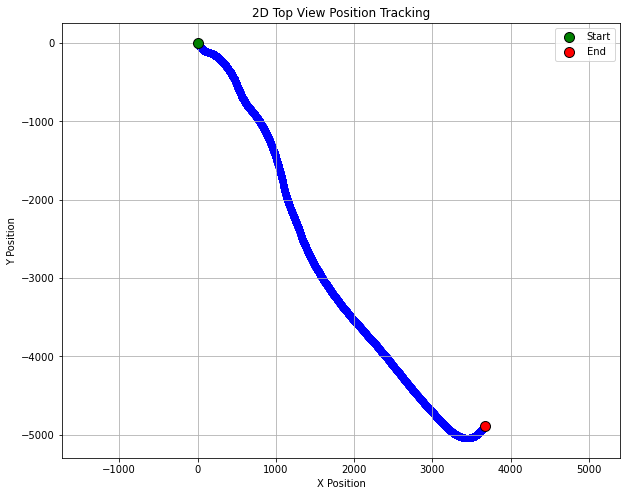

In [55]:
xhs = np.array(xhs)
# Extract x and y positions
x_positions = xhs[:, 0]  # X coordinates
y_positions = xhs[:, 1]  # Y coordinates

# Create the plot
plt.figure(figsize=(10, 8))
plt.plot(x_positions, y_positions, marker='o', linestyle='-', color='b', zorder=1)
plt.title('2D Top View Position Tracking')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.axis('equal')  # This ensures that unit increments are equal on both axes

# Highlight the first position with higher zorder
plt.scatter(x_positions[0], y_positions[0], color='green', s=100, edgecolor='black', label='Start', zorder=2)
# Highlight the last position with higher zorder
plt.scatter(x_positions[-1], y_positions[-1], color='red', s=100, edgecolor='black', label='End', zorder=2)

# Add a legend to identify the start and end
plt.legend()

# Display the plot
plt.show()

### real-time without batch processing

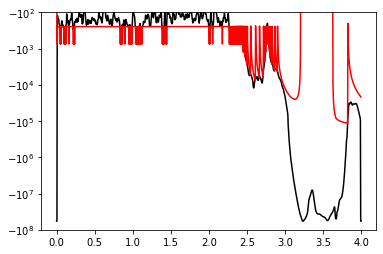

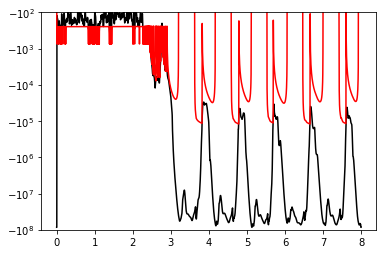

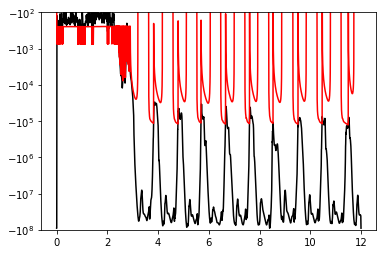

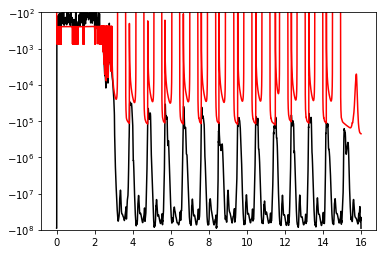

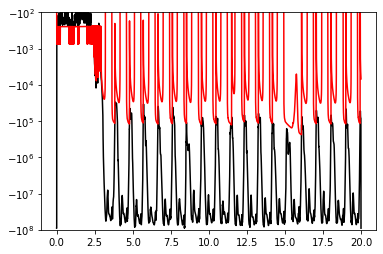

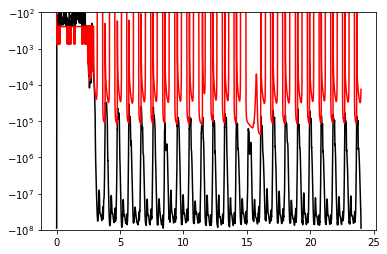

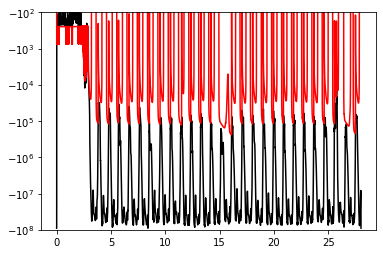

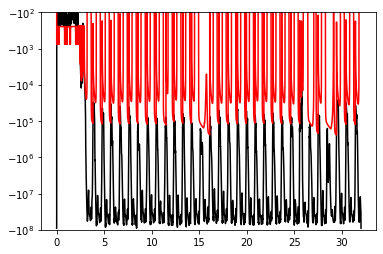

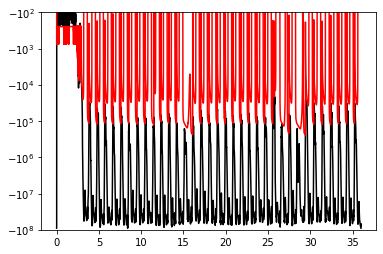

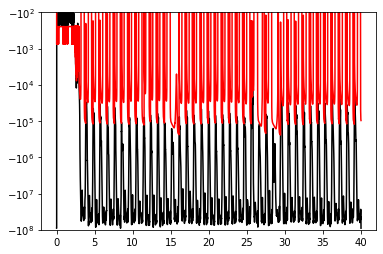

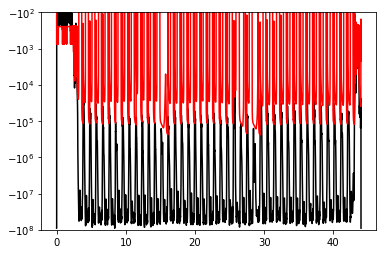

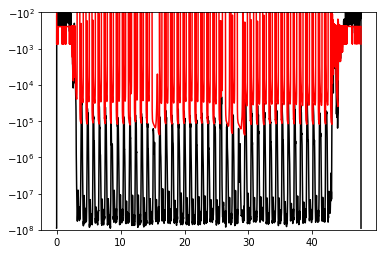

In [65]:
n = 1000
num_batches = len(u[0]) // n
state_position = []
xhs = []
init_P = None
init_quat = None
init_position = None
position = np.zeros((3,1))
state_vector = np.zeros((9, 1))

for i in range(num_batches+1):
    # print((i+1 )* n)
    ui = u[:, :(i+1)*n]
    zupt, logL = detector_adaptive(ui, simdata)
    x_h, _ = ZUPTaidedINS(ui, zupt, logL, True, simdata)
    # zupt , logL = ins.detector(ui)
    # x_h, _, quat, P = ins.baseline(ui, zupt, logL, init_position, init_quat, init_P) # 9, N
    x, y, z = x_h[0:3, -1]
    state_position.append(position.ravel().tolist())

In [66]:
x_h.shape

(9, 11900)

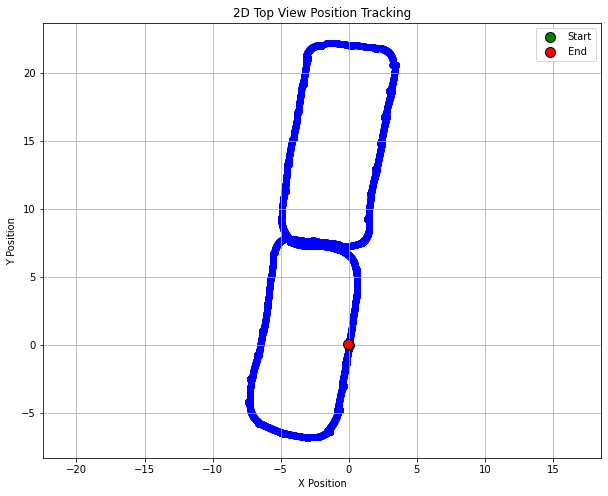

In [67]:
plot_position_tracking(x_h)

### ground truth

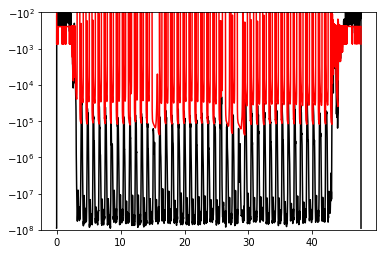

In [60]:
zupt, logL = detector_adaptive(u, simdata)
x_hx, _ = ZUPTaidedINS(u, zupt, logL, True, simdata)

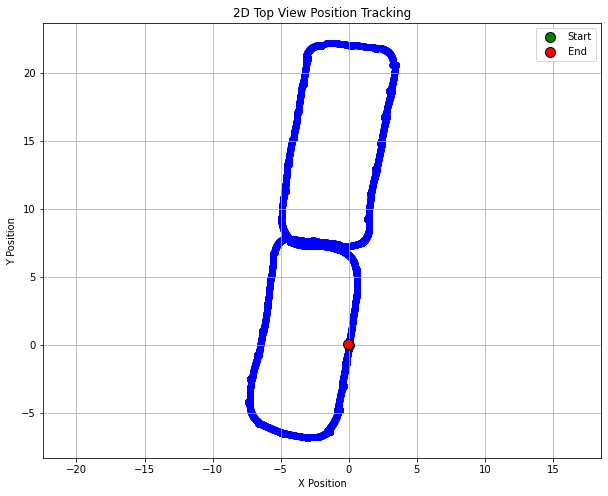

In [45]:
# Extract x and y positions
x_positions = x_hx[0, :]  # X coordinates
y_positions = x_hx[1, :]  # Y coordinates

# Create the plot
plt.figure(figsize=(10, 8))
plt.plot(x_positions, y_positions, marker='o', linestyle='-', color='b', zorder=1)
plt.title('2D Top View Position Tracking')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.axis('equal')  # This ensures that unit increments are equal on both axes

# Highlight the first position with higher zorder
plt.scatter(x_positions[0], y_positions[0], color='green', s=100, edgecolor='black', label='Start', zorder=2)
# Highlight the last position with higher zorder
plt.scatter(x_positions[-1], y_positions[-1], color='red', s=100, edgecolor='black', label='End', zorder=2)

# Add a legend to identify the start and end
plt.legend()

# Display the plot
plt.show()

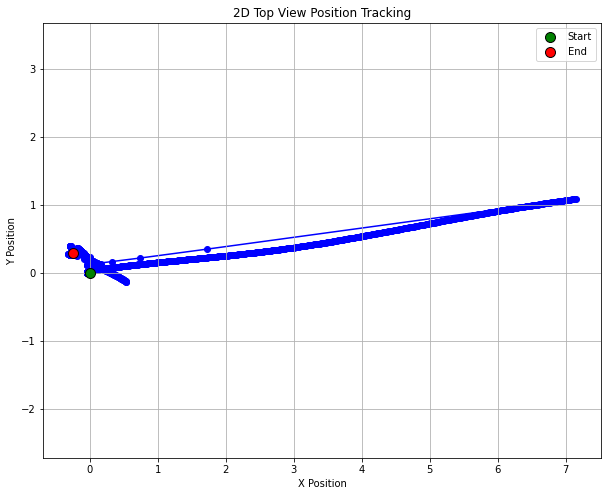

In [ ]:
plot_position_tracking(x_h)

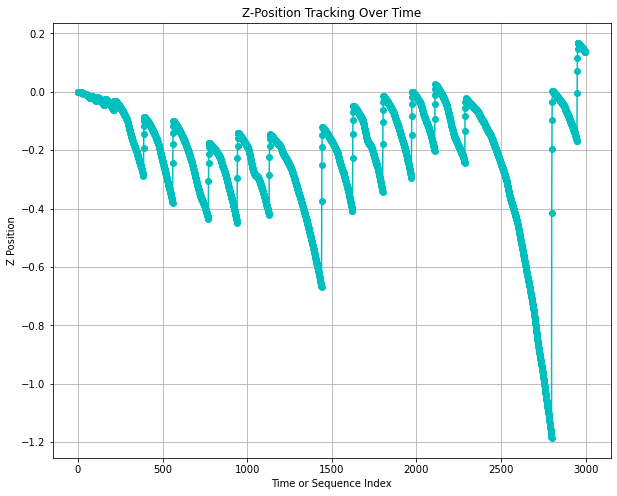

In [ ]:
plot_z_position_tracking(x_h)

Iteration 1 out of 20


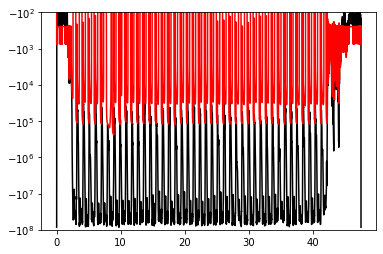

[-0.0890856  -0.02259215  0.4302652 ]


In [ ]:
# Run all the data sets with the adaptive zero-velocity detector
for d in range(D):
    # Show the iteration number
    print(f'Iteration {d+1} out of {D}')

    # Set path
    path = f'Measurement_100521_{simdata["data_sets"][d+1]}/'

    # Load the data
    u = func_loaddataset.func_loaddataset(f'ZUPTaidedINS\{path}')

    # Run the detector
    zupt, logL = detector_adaptive(u, simdata)

    # Run the filter with adaptive threshold
    x_h, _ = ZUPTaidedINS(u, zupt, logL, True, simdata)

    print(x_h[0:3, -1])
    break

    # Calculate the error
    Jadapt += np.dot(x_h[0:3, -1], x_h[0:3, -1])
    Jadapt_all[d, :] = x_h[0:3, -1]

# Calculate mean square error
Jadapt /= D

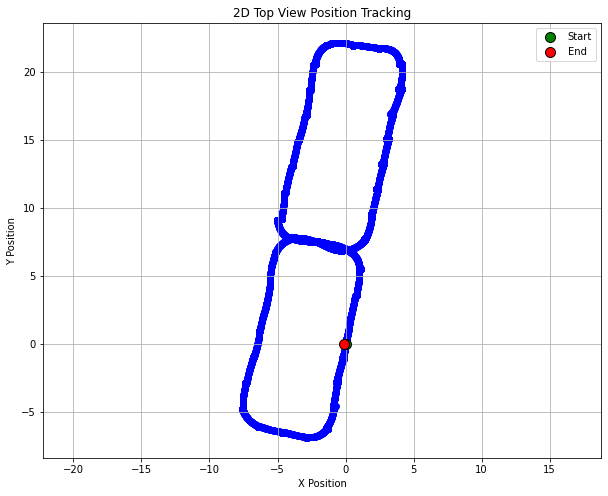

In [ ]:
plot_position_tracking(x_h)

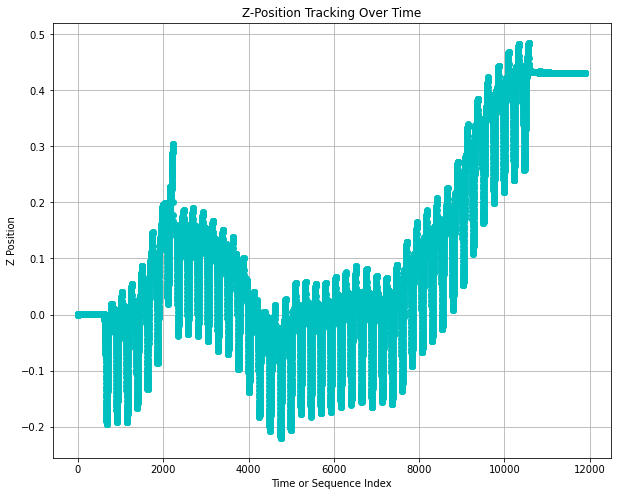

In [ ]:
plot_z_position_tracking(x_h)

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
N = len(u[0])
P, Q, R, H = init_filter(simdata) # checked

x_h, cov, Id = init_vec(N, P, simdata) #checked
x_h[0:9, 0], quat = init_Nav_eq(u, simdata)

In [ ]:
f_u = np.mean(u[0, :20])
f_v = np.mean(u[1, :20])
f_w = np.mean(u[2, :20])

roll = np.arctan2(-f_v, -f_w)
pitch = np.arctan2(f_u, np.sqrt(f_v ** 2 + f_w ** 2))

attitude = np.array([roll, pitch, simdata['init_heading']])
Rb2t = Rt2b(attitude).T

In [ ]:
Rb2t

array([[ 0.99976721,  0.00339294,  0.02130748],
       [ 0.        , -0.9875579 ,  0.1572558 ],
       [ 0.02157593, -0.15721919, -0.98732801]])

In [ ]:
quat

array([-9.96826606e-01, -8.50935406e-04, -1.07549826e-02,  7.88690304e-02])

In [ ]:
x_h.shape, _.shape

((9, 11900), (9, 11900))

In [ ]:
# Run all the data with a fixed threshold
for m in range(M):
    # Show the iteration number
    print(f'Iteration {ctr} out of {Niter}')
    ctr += 1

    for d in range(D):
        print(f'Data set {d+1} out of {D}')

        # Set path
        path = f'Measurement_100521_{simdata["data_sets"][d]}/'

        # Load the data
        u = func_loaddataset.func_loaddataset(f'ZUPTaidedINS\{path}')

        # Update the detector threshold
        simdata['gamma'] = gamma_vec[m]

        # Run the detector
        zupt, logL = detector_adaptive(u, simdata)

        # Run the filter
        x_h, _ = ZUPTaidedINS(u, zupt, logL, False, simdata)

        # Calculate the error
        Jfixed[m] += np.dot(x_h[0:3, -1], x_h[0:3, -1])
        Jfixed_all[m, d, :] = x_h[0:3, -1]

Jfixed /= D

Iteration 1 out of 20
Data set 1 out of 20
Data set 2 out of 20
Data set 3 out of 20
Data set 4 out of 20
Data set 5 out of 20
Data set 6 out of 20
Data set 7 out of 20
Data set 8 out of 20
Data set 9 out of 20
Data set 10 out of 20
Data set 11 out of 20
Data set 12 out of 20
Data set 13 out of 20
Data set 14 out of 20
Data set 15 out of 20
Data set 16 out of 20
Data set 17 out of 20
Data set 18 out of 20
Data set 19 out of 20
Data set 20 out of 20
Iteration 2 out of 20
Data set 1 out of 20
Data set 2 out of 20
Data set 3 out of 20
Data set 4 out of 20
Data set 5 out of 20
Data set 6 out of 20
Data set 7 out of 20
Data set 8 out of 20
Data set 9 out of 20
Data set 10 out of 20
Data set 11 out of 20
Data set 12 out of 20
Data set 13 out of 20
Data set 14 out of 20
Data set 15 out of 20
Data set 16 out of 20
Data set 17 out of 20
Data set 18 out of 20
Data set 19 out of 20
Data set 20 out of 20
Iteration 3 out of 20
Data set 1 out of 20
Data set 2 out of 20
Data set 3 out of 20
Data set 

C:\Users\USER\AppData\Local\Temp\ipykernel_15852\91817824.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('symlog')


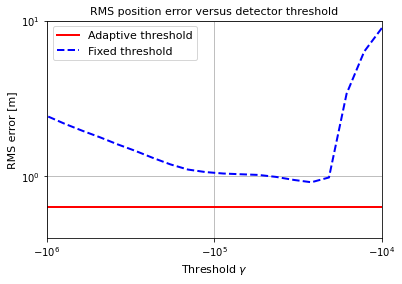

In [ ]:
# Plot the result
plt.figure()
plt.clf()
plt.loglog(-gamma_vec, np.sqrt(Jadapt) * np.ones_like(gamma_vec), 'r', linewidth=2)
plt.loglog(-gamma_vec, np.sqrt(Jfixed), 'b--', linewidth=2)
plt.yscale('symlog')
plt.xscale('symlog')
plt.legend(['Adaptive threshold', 'Fixed threshold'], loc='best', fontsize=11)
plt.title('RMS position error versus detector threshold', fontsize=11)
plt.ylabel('RMS error [m]', fontsize=11)
plt.xlabel('Threshold $\\gamma$', fontsize=11)
plt.axis([-gamma_vec[-1], -gamma_vec[0], 1e-1, 1e1])
plt.grid(True)
plt.box(True)
plt.show()

In [ ]:
# Compute error from concatenated data
print(np.linalg.norm(np.sum(Jadapt_all, axis=0)))
print(np.min(np.sqrt(np.sum(np.sum(Jfixed_all, axis=1) ** 2, axis=1))))

9.84657716783097
16.086072631052826


In [ ]:
gamma_vec.shape , Jadapt.shape

((20,), ())

In [ ]:
Jadapt , Jfixed , Jadapt_all

(0.29527065224207544,
 array([75.64029414, 31.62664756,  6.5861417 ,  0.95893672,  0.82736613,
         0.89041385,  0.97474308,  1.03248211,  1.05223858,  1.07444152,
         1.11821948,  1.19676152,  1.36734909,  1.59834435,  1.86746659,
         2.13362672,  2.44356946,  2.74910081,  3.09523995,  3.50125614]),
 array([[-0.0288682 ,  0.07179067,  0.48529654],
        [-0.0890856 , -0.02259215,  0.4302652 ],
        [-0.06849203, -0.11475815,  0.27874954],
        [ 0.13906644, -0.04541051,  0.41211078],
        [-0.14332786, -0.01901676,  0.33441952],
        [ 0.03029845, -0.09152118,  0.27595421],
        [ 0.10044775, -0.12009581,  0.39355037],
        [ 0.01294933, -0.07123852,  0.48200123],
        [-0.17167173, -0.08397606,  0.45012837],
        [ 0.05451091, -0.01016102,  0.40978265],
        [ 0.01367146, -0.08962598,  0.40591268],
        [-0.44832301, -0.1838653 ,  0.46146713],
        [-0.28100059, -0.20640273,  0.6864638 ],
        [-0.487064  , -0.13643935,  0.52092258]

In [ ]:
np.savetxt('gamma_vec.txt', gamma_vec, delimiter=',', fmt='%.9f')
# np.savetxt('Jadapt.txt', Jadapt, delimiter=',', fmt='%.9f')
np.savetxt('Jfixed.txt', Jfixed, delimiter=',', fmt='%.9f')